# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.  
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта**  

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

**Инструкция по выполнению проекта**  

- Проведите исследовательский анализ набора фотографий.
- Подготовьте данные к обучению.
- Обучите нейронную сеть и рассчитайте её качество.

**Описание данных**

Данные находятся в папке `/datasets/faces/` - переменная `path`.  

В вашем распоряжении одна папка со всеми изображениями (`/final_files`) и CSV-файл `labels.csv` с двумя колонками: `file_name` и `real_age`.

In [1]:
# импорт библиотек

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# подготовка выборки

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
features, target = next(train_gen_flow)

## Исследовательский анализ данных

In [4]:
# проверка корректного вывода

labels.head(5)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
# проверка типов данных и наличия пропусков

labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
# проверка диапазона значений

labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


<AxesSubplot:xlabel='Real age', ylabel='Count'>

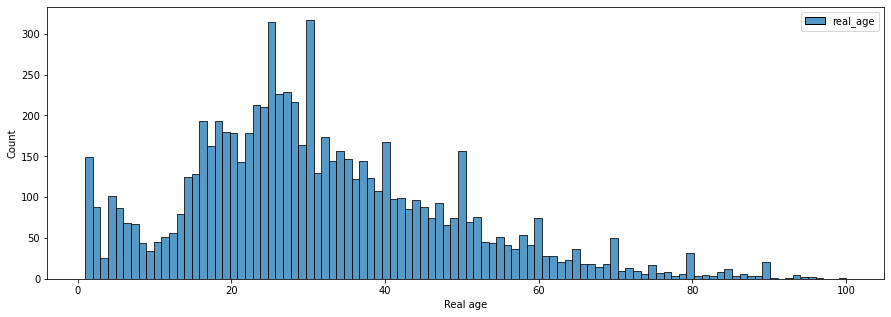

In [7]:
# проверка распределения значений

plt.figure(figsize=(15, 5))
plt.xlabel("Real age")

sns.histplot(labels, bins=100)

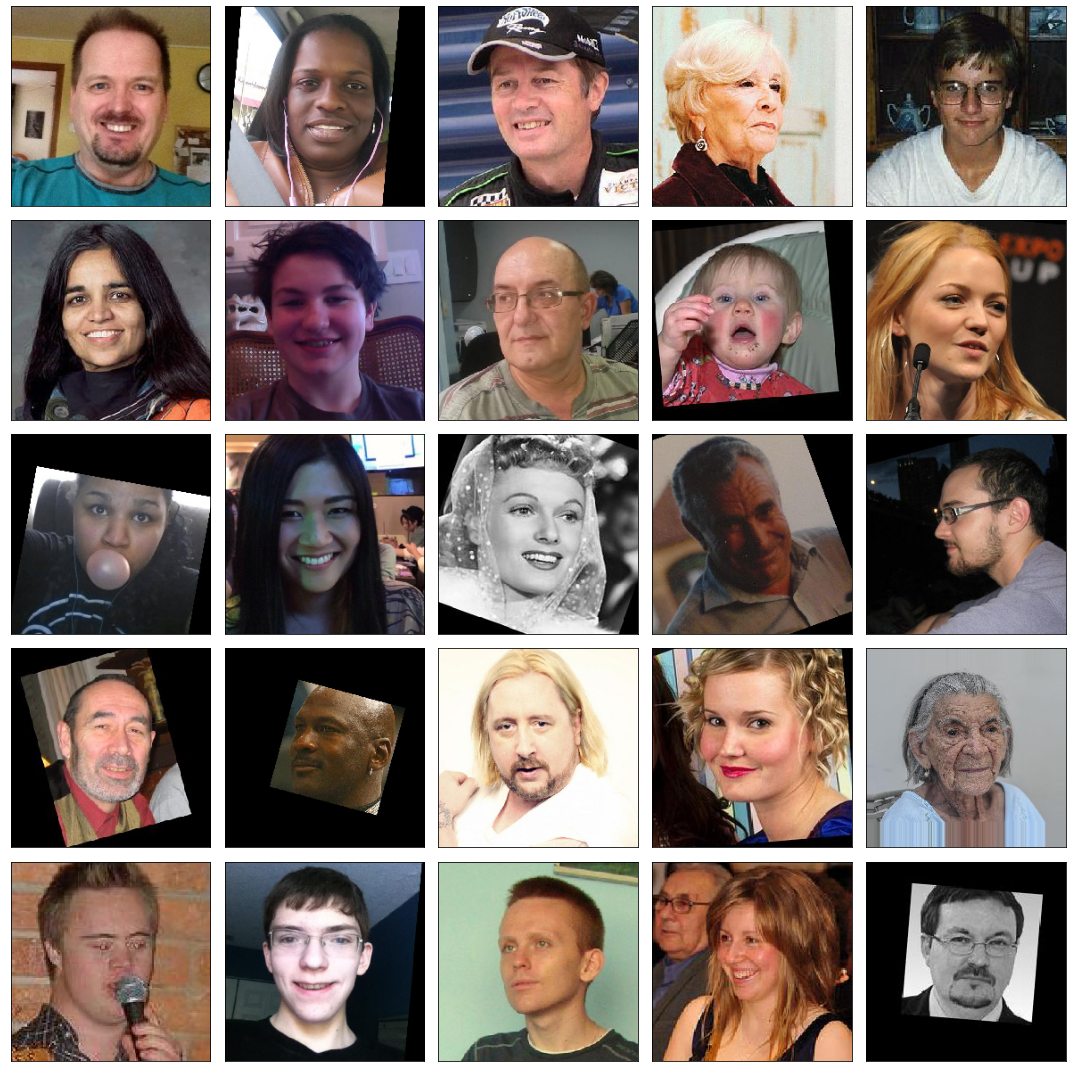

In [8]:
# предварительный обзор изображений

fig = plt.figure(figsize=(15,15))
for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

Для проекта предоставлен датасет состоящий из 7591 фотографии с метками возраста. Возрастные метки представлены диапазоном от 1 до 100 лет. Основное количество возрастных меток приходится на диапазон от 18 до 40 лет.  
Распределение фотографий пожилых людей охватываешь широкую возрастную группу, на каждый год возраста приходится небольшое количество фотографий.  
Большое количество фотографий с лицами младенцев. Возможно следует от них избавиться, чтобы не разбавлять пул изображений с актуальными для целей проекта лицами.  

Пропусков нет. Изменения типов данных не требуется.  

На изображениях лица представлены с разных углов обзора. Многие изображения содержат посторонние объекты. Возможно присутствие других лиц на фоне окружающем основное лицо. Изображения значительно отличаются по качеству, есть "замыленные". Во многих преобладает один цвет, также есть черно-белые изображения. Многие изображения уже повернуты, вероятно чтобы выровнять лицо относительно сторон, но есть примеры неудачного разворота.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# импорт библиотек

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error


def load_train(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        #horizontal_flip=True,
        #vertical_flip=True,
        #width_shift_range=0.2,
        #height_shift_range=0.2
        )
    
    datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return datagen_flow


def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
        )
    
    datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return datagen_flow


def create_model(input_shape):
    
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False) 
    # замораживаем ResNet50 без верхушки
    # backbone.trainable = False
                 
    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    opt = Adam(lr=0.0001)
    model.compile(optimizer=opt, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
        validation_data=test_data,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2) 
        
    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 356 steps, validate for 119 steps
Epoch 1/5
2022-10-02 11:43:36.865529: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-10-02 11:43:37.289903: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 59s - loss: 207.8712 - mae: 10.5484 - val_loss: 494.6414 - val_mae: 16.8846
Epoch 2/5
356/356 - 52s - loss: 68.7803 - mae: 6.3590 - val_loss: 118.7468 - val_mae: 8.0307
Epoch 3/5
356/356 - 51s - loss: 37.6263 - mae: 4.7464 - val_loss: 96.6456 - val_mae: 7.4686
Epoch 4/5
356/356 - 47s - loss: 24.5224 - mae: 3.8737 - val_loss: 80.9229 - val_mae: 6.6899
Epoch 5/5
356/356 - 51s - loss: 18.1938 - mae: 3.3060 - val_loss: 71.7849 - val_mae: 6.3600

```

## Анализ обученной модели

Была дана задача обучения модели, способной определить примерный возраст человека по фотографии.  
Для выполнения проекта былпредоставлен набор подготовленных фотографий и их разметка по возрасту запечатленного человека.  
Была поставлена задача достижения показателя метрики Mean Absolute Error (MAE) менее 8.

По итогам исследования достигнуто значение MAE равное 6.36 на тестовой выборке, что соответствует требованиям задания.  
Значение достигнуто путем использования архитектуры `ResNet50` и метода оптимизации `Adam` с параметром `learning_rate=0.0001`. Аугментация и заморозка не применялись. 